In [2]:
from towhee import pipe, ops, DataCollection, AutoConfig

auto_config = AutoConfig.LocalGPUConfig()
auto_config.config

E:\sourcecode\keep_learning\.venv\Lib\site-packages\pydantic\_internal\_fields.py:160: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


{'device': 0}

# Pipeline

In [2]:
add_one = (
    pipe.input('x')
    .map('x', 'y', lambda x: x + 1)
    .output('y')
)

res = add_one(0)
DataCollection(res).show()

y
1


`Pipeline` 可以构建复杂的数据处理流程，支持多输入、多输出，支持多种数据处理操作，如 map、filter、reduce 等。其中 `operator` 是一个函数，接受一个输入，返回一个输出，内建有一些常用的：
- Data processing operators。例如：image transformations, image/audio/video decode, tokenizers, vector normalizers 等
- Neural network models or libraries。例如：CLIP4Clip 预训练模型, HF 模型适配器, OpenAI embedding API wrapper 等
- Connectors。例如 Milvus connector, HBase connector 等

url,img,embedding
https://github.com/towhee-io/towhee/raw/main/towhee_logo.png,,"[0.0, 0.0, 0.0, ...] shape=(2048,)"

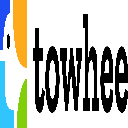

<Figure size 128x128 with 0 Axes>

In [3]:
# 演示使用 `TIMM`(Torch Image Model) 产生 Image embeddings

img_embedding = (
    pipe.input('url')  # 输入参数
    .map('url', 'img', ops.image_decode.cv2())  # 使用 url 作为输入，通过 cv2 解码为 img，通过 img 返回
    .map('img', 'embedding', ops.image_embedding.timm(model_name='resnet50'))  # 使用 img 作为输入，通过 timm 产生 特征向量，通过 embedding 返回
    .output('url', 'img', 'embedding')
)

url = 'https://github.com/towhee-io/towhee/raw/main/towhee_logo.png'
res = img_embedding(url)
DataCollection(res).show()

# Node

- input
- output
- map
- flat_map
- filter
- window
- time_window
- window_all
- concat

# Map

对它的输入的每个元素进行 `fn` 操作，返回一个新的集合。

![Map](./images/00_towhee_map.png)

演示过程

![Map2](./images/00_towhee_map2.png)

In [4]:
text_embedding = (pipe.input('text')
                  .map('text', 'embedding', ops.sentence_embedding.transformers(model_name='all-MiniLM-L6-v2'))
                  .output('text', 'embedding')
                  )

data = ['Hello, world.', 'How are you?']
res = text_embedding.batch(data)

DataCollection(res[0]).show()

text,embedding
"Hello, world.","[-0.21680176, 0.17567122, -0.063922144, ...] shape=(384,)"


# FlatMap

`flap map` 将函数应用于每一行输入后对结果进行展平，并分别返回展平后的数据。返回后的数据长度可能会输入数据长度相同，也可能大于它。这个是与 `map` 最大的区别，`map` 的输出结果长度与输入长度相同。

![FlatMap](./images/00_flat_map_intro.png)

Using cache found in C:\Users\ping/.cache\torch\hub\ultralytics_yolov5_master


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'wheel>=0.38.0'] not found, attempting AutoUpdate...
   ---------------------------------------- 207.3/207.3 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 65.8/65.8 kB ? eta 0:00:00
   ---------------------------------------- 62.7/62.7 kB ? eta 0:00:00

requirements: AutoUpdate success  6.5s, installed 2 packages: ['gitpython>=3.1.30', 'wheel>=0.38.0']
requirements:  Restart runtime or rerun command for updates to take effect



YOLOv5  2024-5-17 Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


img,object,class,score,embedding
,,apple,0.8343068957328796,"[0.0, 0.0, 0.0, ...] shape=(2048,)"
,,banana,0.6313368082046509,"[0.032813743, 0.0, 0.11794818, ...] shape=(2048,)"

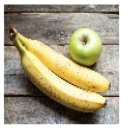
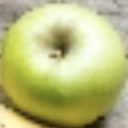
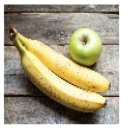
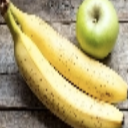

In [5]:
obj_embedding = (
    pipe.input('url')
    .map('url', 'img', ops.image_decode.cv2_rgb())
    .flat_map('img', ('box', 'class', 'score'), ops.object_detection.yolo())
    .flat_map(('img', 'box'), 'object', ops.towhee.image_crop())
    .map('object', 'embedding', ops.image_embedding.timm(model_name='resnet50'))
    .output('img', 'object', 'class', 'score', 'embedding')
)

data = 'https://towhee.io/object-detection/yolo/raw/branch/main/objects.png'
res = obj_embedding(data)
res.size  # return 2
DataCollection(res).show()

上述结果的图形化解释：

![FlatMap](./images/00_flat_map_example_2.png)

## Filter

`filter` 函数的 `input_schema` 与 `output_schema` 应该有相同的列数。

图形化解释：

![Filter](./images/00_filter_intro.png)

Using cache found in C:\Users\ping/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-5-17 Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


object,class,score,embedding,obj_res
,apple,0.8343068957328796,"[0.0, 0.0, 0.0, ...] shape=(2048,)","[([448, 153, 663, 375], 'apple', 0.8343068957328796),([63, 177, 710, 607], 'banana', 0.6313368082046509)] len=2"
,banana,0.6313368082046509,"[0.032813743, 0.0, 0.11794818, ...] shape=(2048,)","[([448, 153, 663, 375], 'apple', 0.8343068957328796),([63, 177, 710, 607], 'banana', 0.6313368082046509)] len=2"

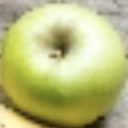
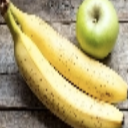

In [6]:
obj_filter_embedding = (
    pipe.input('url')
    .map('url', 'img', ops.image_decode.cv2_rgb())
    .map('img', 'obj_res', ops.object_detection.yolo())
    .filter(('img', 'obj_res'), ('img', 'obj_res'), 'obj_res', lambda x: len(x) > 0)
    .flat_map('obj_res', ('box', 'class', 'score'), lambda x: x)
    .flat_map(('img', 'box'), 'object', ops.towhee.image_crop())
    .map('object', 'embedding', ops.image_embedding.timm(model_name='resnet50'))
    .output('object', 'class', 'score', 'embedding', 'obj_res')
)

data = ['https://towhee.io/object-detection/yolo/raw/branch/main/objects.png',
        'https://github.com/towhee-io/towhee/raw/main/assets/towhee_logo_square.png']
res = obj_filter_embedding.batch(data)
DataCollection(res[0]).show()

上述结果的图形化解释：

![Filter](./images/00_filter_example_2.png)

## Window

根据指定的窗口大小（`size`）和步长（`step`）将输入行批量分成多个一组一组的行。`size` 决定了窗口的长度，`step` 决定了窗口从它上一个开始的移动长度。如果 `step` 小于 `size`，那么窗口将会有重叠。节点将 `fn` 作用在已经窗口化的数据（组）上，产生一行结果数据。

![Window](./images/00_window_intro_1.png)

窗口节点应用函数：

![Window](./images/00_window_intro_2.png)

url,frame,embedding
https://raw.githubusercontent.com/towhee-io/examples/0.7/video/reverse_video_search/tmp/Ou1w86qEr58.gif,,"[0.00035400296, 0.0, 0.027393661, ...] shape=(2048,)"
https://raw.githubusercontent.com/towhee-io/examples/0.7/video/reverse_video_search/tmp/Ou1w86qEr58.gif,,"[0.0, 0.0, 0.0, ...] shape=(2048,)"

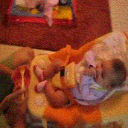
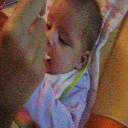

In [8]:
import random

video_frame_embedding = (
    pipe.input('url')
    .flat_map('url', 'frame', ops.video_decode.ffmpeg())
    .window('frame', 'frame', 10, 10, lambda x: x[random.randint(0, len(x) - 1)])
    .map('frame', 'embedding', ops.image_embedding.timm(model_name='resnet50'))
    .output('url', 'frame', 'embedding')
)

data = 'https://raw.githubusercontent.com/towhee-io/examples/0.7/video/reverse_video_search/tmp/Ou1w86qEr58.gif'
res = video_frame_embedding(data)
DataCollection(res).show()

## Time Window

时间窗口节点用于对具有时间序列的行进行批处理，例如音频或视频帧。

`time_window` 与 `window` 类似，但批处理规则是基于时间戳列 `timestamp_col` 应用的。 `size` 是每个窗口的时间间隔，`step` 决定一个窗口距离前一个窗口移动多长时间。请注意，如果步长小于大小，窗口将重叠。

![Time Window](./images/00_time_window_intro_1.png)

![Time Window](./images/00_time_window_intro_2.png)


url,frame,embedding
https://raw.githubusercontent.com/towhee-io/examples/0.7/video/reverse_video_search/tmp/Ou1w86qEr58.gif,,"[0.0, 0.003460704, 0.019475924, ...] shape=(2048,)"
https://raw.githubusercontent.com/towhee-io/examples/0.7/video/reverse_video_search/tmp/Ou1w86qEr58.gif,,"[0.0, 0.0, 0.0, ...] shape=(2048,)"

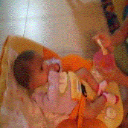
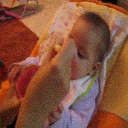

In [10]:
import random

video_frame_embedding = (
    pipe.input('url')
    .flat_map('url', 'frame', ops.video_decode.ffmpeg())
    .map('frame', 'ts', lambda frame: frame.timestamp)
    .time_window('frame', 'frame', 'ts', 1, 1, lambda x: x[random.randint(0, len(x) - 1)])
    .map('frame', 'embedding', ops.image_embedding.timm(model_name='resnet50'))
    .output('url', 'frame', 'embedding')
)

data = 'https://raw.githubusercontent.com/towhee-io/examples/0.7/video/reverse_video_search/tmp/Ou1w86qEr58.gif'
res = video_frame_embedding(data)
DataCollection(res).show()

## Window All

![Window All](./images/00_window_all_intro.png)

In [3]:
import numpy as np


def merge_ndarray(x):
    return np.concatenate(x).reshape(-1, x[0].shape[0])


video_embedding = (
    pipe.input('url')
    .flat_map('url', 'frame', ops.video_decode.ffmpeg())
    .map('frame', 'embedding', ops.image_embedding.timm(model_name='resnet50'))
    .window_all('embedding', 'video_embedding', merge_ndarray)
    .output('url', 'video_embedding')
)

data = 'https://raw.githubusercontent.com/towhee-io/examples/0.7/video/reverse_video_search/tmp/Ou1w86qEr58.gif'
res = video_embedding(data)
DataCollection(res).show()

url,video_embedding
https://raw.githubusercontent.com/towhee-io/examples/0.7/video/reverse_video_search/tmp/Ou1w86qEr58.gif,"[0.027766084, 0.00039201154, 0.32347596, ...] shape=(16, 2048)"


## Concat

![Concat](./images/00_concat_intro.png)

img,text,img_embedding,text_embedding
,A dog looking at a computer in bed.,"[-0.32013965, -1.1389153, -0.6685712, ...] shape=(512,)","[0.16456747, 0.19578558, -0.281165, ...] shape=(512,)"

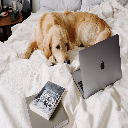

<Figure size 128x128 with 0 Axes>

In [5]:
in_pipe = pipe.input('url', 'text')

img_embedding = (
    in_pipe.map('url', 'img', ops.image_decode.cv2_rgb())
    .map('img', 'img_embedding', ops.image_text_embedding.clip(model_name='clip_vit_base_patch32', modality='image'))
)

text_embedding = in_pipe.map('text', 'text_embedding', ops.image_text_embedding.clip(model_name='clip_vit_base_patch32', modality='text'))

img_text_embedding = (
    img_embedding.concat(text_embedding)
    .output('img', 'text', 'img_embedding', 'text_embedding')
)

img = 'https://towhee.io/object-detection/yolov5/raw/branch/main/test.png'
text = 'A dog looking at a computer in bed.'
res = img_text_embedding(img, text)
DataCollection(res).show()

流程解释：

![Concat](./images/00_concat_example_1.png)

![Concat2](./images/00_concat_example_2.png)


如果多个上游管道中的列共享相同的列名，则 concat 节点将按照管道的顺序覆盖列中的数据。 
concat 节点要求上游管道源自相同的输入。较大管道的 DAG 只有一个输入和一个输出节点。